In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Field Generation

(np.float64(0.0), np.float64(100.0), np.float64(0.0), np.float64(100.0))

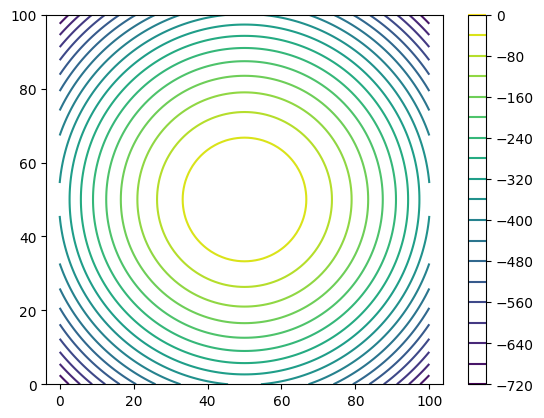

In [2]:
width=500

x_circ = np.linspace(-width // 2, width // 2, 101)  
y_circ = np.linspace(-width // 2, width // 2, 101)
X_circ, Y_circ = np.meshgrid(x_circ, y_circ)

x0_circ, y0_circ = 0, 0

A = -2/350
Psi_circ = A*( (X_circ-x0_circ)**2 + (Y_circ-y0_circ)**2 )

u_circ, v_circ = (-2*A*(Y_circ - y0_circ)).T, (2*A*(X_circ - x0_circ)).T

plt.contour(Psi_circ, 20)
plt.colorbar()
plt.axis('equal')

(np.float64(-250.0), np.float64(250.0), np.float64(-250.0), np.float64(250.0))

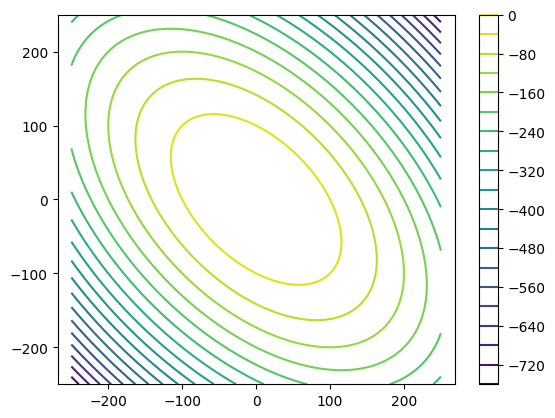

In [3]:
width=500

x_ell = np.linspace(-width // 2, width // 2, 101)  
y_ell = np.linspace(-width // 2, width // 2, 101) 
X_ell, Y_ell = np.meshgrid(x_ell, y_ell)

x0_ell, y0_ell = 0, 0

q11, q22, q12 = 2, 2, 1
A = -1/500
q11 *= A
q22 *= A
q12 *= A
Q = np.array([[q11, q12], [q12, q22]])

XY = np.stack((X_ell, Y_ell), axis=-1)  # Shape (101, 101, 2)
Psi_ell = np.einsum("...i,ij,...j->...", XY, Q, XY)

u_ell = (-2*q22*(Y_ell-y0_ell) - 2*q12*(X_ell-x0_ell)).T
v_ell =  (2*q11*(X_ell-x0_ell) + 2*q12*(Y_ell-y0_ell)).T

plt.contour(X_ell, Y_ell, Psi_ell, 20)
plt.colorbar()
plt.axis('equal')

## MOCAspace

$$
\Psi(x,y) = (\mathbf{x}-\mathbf{x_0})^T Q (\mathbf{x}-\mathbf{x_0})
$$

$$
\Psi(x,y) = q_{11}(y - y_0) - 2q_{22}(y - y_0)^2 + 2q_{12}(x - x_0)(y - y_0)
$$

$$
u = -2q_{22}(y - y_0) - 2q_{12}(x - x_0)
$$

$$
v = 2q_{11}(x - x_0) + 2q_{12}(y - y_0)
$$

$$
R = \sum \left( (u_i - u)^2 + (v_i - v)^2 \right)
$$



In [4]:
def moca_space(xi, yi, ui, vi):
    from scipy.optimize import least_squares

    def residuals(params, x, y, u_i, v_i):
        x0, y0, q11, q12, q22 = params
        u = -2 * q22 * (y - y0) - 2 * q12 * (x - x0)
        v =  2 * q11 * (x - x0) + 2 * q12 * (y - y0)
        return np.concatenate([(u - u_i), (v - v_i)])

    def fit_params(x, y, u_i, v_i):
        x0_init, y0_init = np.mean(x), np.mean(y)
        q11_init, q12_init, q22_init = 1.0, 0.0, 1.0  # Initial guesses
        params_init = [x0_init, y0_init, q11_init, q12_init, q22_init]
        result = least_squares(residuals, params_init, args=(x, y, u_i, v_i))
        return result.x 

    x0, y0, q11, q12, q22 = fit_params(xi, yi, ui, vi)

    w = 2*(q11 + q22)
    
    return x0, y0, q11, q12, q22, w

20
x0: 2.2443597428210366e-13, y0: -2.0663723199793347e-13
60
x0: -7.300707044881777e-13, y0: 5.858199633669483e-13
100
x0: -5.105857536357068e-12, y0: 1.9046364894861716e-12
140
x0: -2.121651343313705e-12, y0: 1.086797605102702e-12


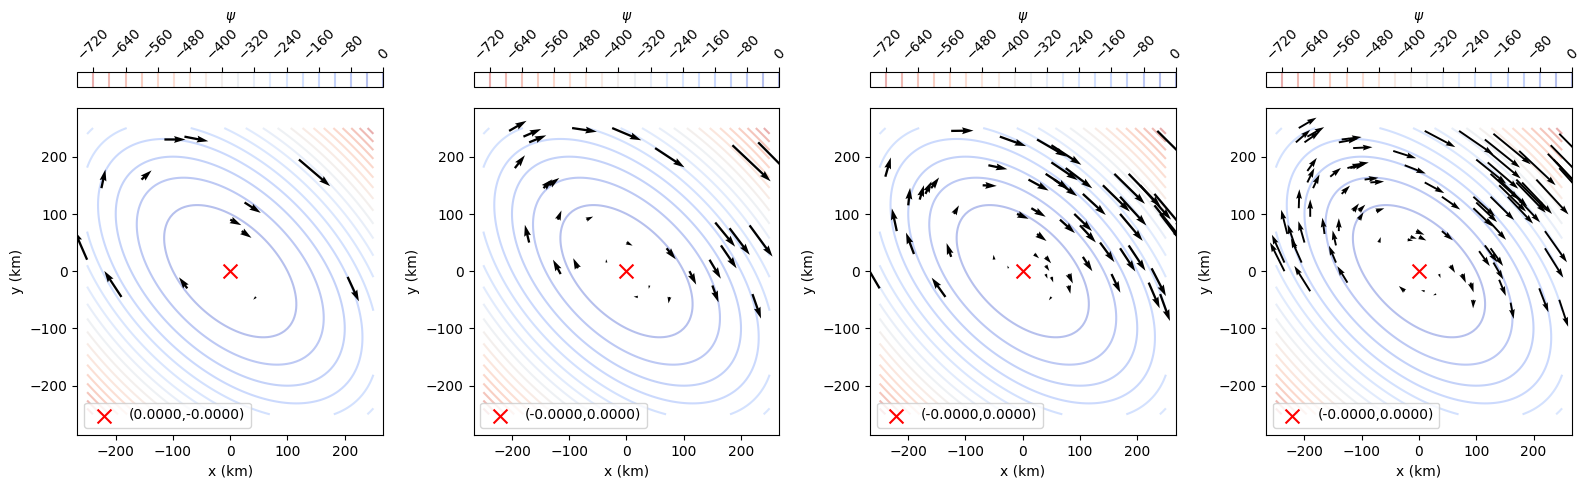

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for k, ax in enumerate(axs):
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=20*(2*k+1), replace=False)
    print(20*(2*k+1))

    random_indices = random_indices[random_indices > 4000] # restriction

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u_ell.T[row_indices, col_indices]
    vi = v_ell.T[row_indices, col_indices]
    xi = X_ell[row_indices, col_indices]
    yi = Y_ell[row_indices, col_indices]

    # cs = np.hypot(u_ell, v_ell)
    c = ax.contour(x_ell, y_ell, Psi_ell.T, cmap='coolwarm_r', levels=20, zorder=-1, alpha=.4)

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k', scale=20)

    x0, y0, q11, q12, q22, w = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0}, y0: {y0}")

    sca = ax.scatter(x0, y0, color='r', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')

    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label=r'$\psi$')
    cbar.ax.tick_params(axis='x', labelrotation=45)

    ax.legend([sca], [f'({x0:.4f},{y0:.4f})'], loc='lower left')

plt.tight_layout()
plt.show()



## Modelled Eddy



In [6]:
def calculate_eddy(width=500000, L=1e5, f0=None, rho0=1025, q11=1., q22=1., q12=0.):
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))
    g = 9.81
    x = np.linspace(-width // 2, width // 2, 101)
    y = np.linspace(-width // 2, width // 2, 101)
    x_2d, y_2d = np.meshgrid(x, y, indexing='ij')
    
    x_c = 0
    y_c = 0

    X = np.stack([x_2d - x_c, y_2d - y_c], axis=0) 
    Q = np.array([[q11, q12], [q12, q22]]) 
    
    r_c = np.sqrt(np.einsum('i...,ij,j...->...', X, Q, X))

    sigma = -2 * np.exp(-r_c**2 / L**2)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy
    
    U = -g / f0 * d_sigma_dy
    V = g / f0 * d_sigma_dx
    
    return U, V, x/1000, y/1000

u, v, x, y = calculate_eddy()
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]


x0: -22.320433, y0: -8.731875
x0: 7.713178, y0: -13.226742
x0: -26.141689, y0: -23.474224
x0: 5.290373, y0: -5.943612


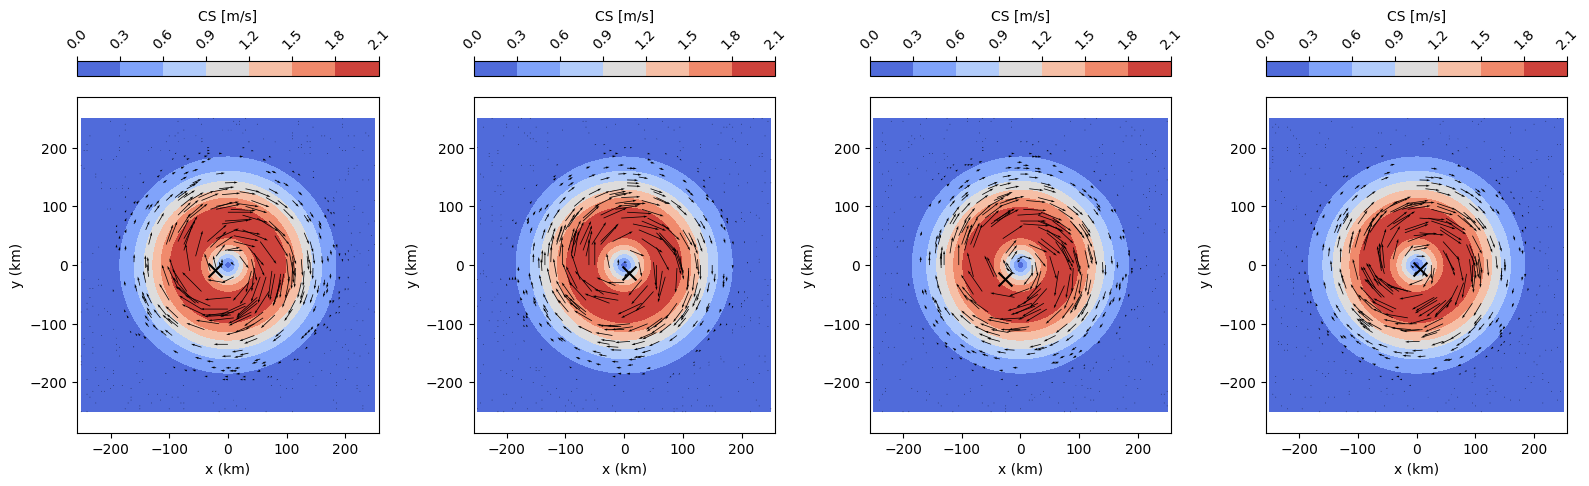

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    random_indices = np.random.choice(u_ell.shape[0] * u_ell.shape[1], size=600, replace=False)

    row_indices, col_indices = np.unravel_index(random_indices, u_ell.shape)

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22, w = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0:2f}, y0: {y0:2f}")

    ax.scatter(x0, y0, color='k', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(16, 5))

for ax in axs:
    
    x_search, y_search = 0, 0
    mask = np.hypot(X - x_search, Y - y_search) < 100
    # valid_indices = np.argwhere(mask == 1)  # Get row, col indices of valid points

    # selected_indices = valid_indices[np.random.choice(valid_indices.shape[0], size=20, replace=False)]

    # row_indices, col_indices = selected_indices[:, 0], selected_indices[:, 1]

    row_indices, col_indices = np.where(mask)

    ui = u.T[row_indices, col_indices]
    vi = v.T[row_indices, col_indices]
    xi = X[row_indices, col_indices]
    yi = Y[row_indices, col_indices]

    cs = np.hypot(u, v)
    c = ax.contourf(x_ell, y_ell, cs.T, cmap='coolwarm')

    # ax.scatter(xi, yi, color='k', marker='.')
    ax.quiver(xi, yi, ui, vi, color='k')

    x0, y0, q11, q12, q22, w = moca_space(xi, yi, ui, vi)
    print(f"x0: {x0:2f}, y0: {y0:2f}")

    ax.scatter(x0, y0, color='k', marker='x', s=100)

    ax.axis('equal')
    ax.set_xlabel('x (km)')
    ax.set_ylabel('y (km)')


    cbar = fig.colorbar(c, ax=ax, orientation='horizontal', location='top', label='CS [m/s]')
    cbar.ax.tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()

x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000
x0: -0.000000, y0: 0.000000


# Elliptical Vortex

In [9]:
u, v, _, _ = calculate_eddy(q11=2, q22=2, q12=1)

In [10]:
%%capture

df_error = pd.DataFrame(columns=['Boundary', 'i', 'j', 'r', 'xc', 'yc', 'Error'])

for boundary in [35, 40, 45]:
    for i in range(boundary, u.shape[0] - boundary, 2):
        for j in range(boundary, u.shape[1] - boundary, 2):
    
            for r_rel in [2, 5, 10, 20]:

                mask = (np.hypot(X - X[i, j], Y - Y[i, j]) < r_rel).T
                xi, yi = X[mask], Y[mask]
                ui, vi = u.T[mask], v.T[mask]
                
                x0_rel, y0_rel, _, _, _, _ = moca_space(xi, yi, ui, vi)

                err = np.hypot(x0_rel, y0_rel)
        
                df_error.loc[len(df_error)] = {'Boundary': boundary, 'i': i, 'j': j, 'r': r_rel, 'xc': x0_rel, 'yc': y0_rel, 'Error': err}
            

In [11]:
import matplotlib.patches as mpatches

fig, axs = plt.subplots(6, 4, figsize=(15,22))

tgs = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']

spacing, scale, width = 2, 40, 0.002

vmaxs = [35, 70, 100]
dx = x[1] - x[0]
for i, r_check in enumerate([2, 5, 10, 20]):

    for j, boundary in enumerate(np.flip(df_error['Boundary'].unique())):    
    
        axs[2*j,i].quiver(x[::spacing], y[::spacing], u[::spacing, ::spacing].T, v[::spacing, ::spacing].T, 
                   alpha=0.4, scale=scale, width=width, zorder=0)
    
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[u.shape[1] - boundary - 1], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[u.shape[0] - boundary - 1]], [y[boundary], y[boundary]], 'r', zorder=1)
        axs[2*j,i].plot([x[boundary], x[boundary]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        axs[2*j,i].plot([x[u.shape[0] - boundary - 1], x[u.shape[0] - boundary - 1]], [y[boundary], y[u.shape[1] - boundary - 1]], 'r', zorder=1)
        
        df_rel = df_error.loc[(df_error['r'] == r_check) & (df_error['Boundary'] == boundary)].copy()
    
        def get_quadrant(i, j, center):
            if i >= center[0] and j > center[1]:
                return 1  # Top-right
            elif i < center[0] and j >= center[1]:
                return 2  # Top-left
            elif i <= center[0] and j < center[1]:
                return 3  # Bottom-left
            else:
                return 4  # Bottom-right
        
        df_rel['Q'] = df_rel.apply(lambda row: get_quadrant(row['i'], row['j'], (u.shape[0]//2, v.shape[1]//2)), axis=1)
    
        # Define legend locations
        legend_locs = {1: 'upper right', 2: 'upper left', 3: 'lower left', 4: 'lower right'}
        scatter = axs[2*j, i].scatter(df_rel['xc'], df_rel['yc'], c=df_rel['Q'], marker='.', zorder=2, cmap='tab10', alpha=.8)
        unique_q = np.append(df_rel['Q'].unique(),0)
        for q in unique_q:
            if q in legend_locs:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc=legend_locs[q], frameon=False)
                axs[2*j, i].add_artist(legend)  # Keep adding legends instead of replacing
            else:
                handle = mpatches.Patch(color=scatter.cmap(scatter.norm(q)), label=f'Q{q}')
                legend = axs[2*j, i].legend(handles=[handle], loc='upper center', frameon=False)
                legend.set_visible(False)

        axs[2*j,i].axhline(y=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        axs[2*j,i].axvline(x=0, color='k', zorder=-1, linewidth=.5, alpha=.5)
        
        axs[2*j,i].axis('equal')
        axs[2*j,i].set_xlim(-100, 100)
        axs[2*j,i].set_ylim(-100, 100)
        axs[2*j,i].set_title(f'r={r_check*dx}')
        axs[2*j,i].set_xlabel('x (km)')
        axs[2*j,i].set_ylabel('y (km)')

        axs[2*j,i].text(-0.2, 1.15, tgs[4*j+i]+'1)', transform=axs[2*j,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
        # plot2
        
        x_unique = np.unique(x[df_rel['i']])
        y_unique = np.unique(y[df_rel['j']])
        
        z_2d = np.full((len(y_unique), len(x_unique)), np.nan)
        
        # Fill the 2D z array with the corresponding z values
        for xi, yi, zi in zip(x[df_rel['i']], y[df_rel['j']], df_rel['Error']):
            x_idx = np.where(x_unique == xi)[0][0]
            y_idx = np.where(y_unique == yi)[0][0]
            z_2d[y_idx, x_idx] = zi
        
        pcl = axs[2*j+1,i].pcolor(x_unique, y_unique, z_2d, vmin=0, vmax=vmaxs[j], cmap='coolwarm')
        cbar = plt.colorbar(pcl, ax=axs[2*j+1, i], orientation='horizontal', location='top', label='[km]')
        axs[2*j+1,i].axis('equal')
    
        axs[2*j+1,i].set_xlabel('x (km)')
        axs[2*j+1,i].set_ylabel('y (km)')

        axs[2*j+1,i].text(-0.2, 1.15, tgs[4*j+i]+'2)', transform=axs[2*j+1,i].transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
plt.tight_layout()
plt.show()

### ROMS

In [12]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

In [13]:
df_MOCA = pd.DataFrame(columns=['Eddy', 'Day', 'xc', 'yc', 'nic', 'njc', 'z', 'Depth', 'w'])
for eddy in the_frontier_eddies:

    var = 1 if eddies[eddy].iloc[0]['Vort'] > 0 else -1 # 1 for anti-cyclone

    for t in range(30): 

        U_roms = sample_data[eddy]['T'+str(t)]['U']
        V_roms = sample_data[eddy]['T'+str(t)]['V']
        
        x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
        X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]

        xc_pre, yc_pre = 0, 0
        nic, njc = U_roms.shape[0]//2, U_roms.shape[1]//2
        r_roms = 5
        for depth_lvl in range(22):

            if not (r_roms <= nic < U_roms.shape[0] - r_roms and r_roms <= njc < U_roms.shape[1] - r_roms):
                break

            u_roms, v_roms = U_roms[:, :, depth_lvl], V_roms[:,:, depth_lvl]

            mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
            xi, yi = X_roms[mask], Y_roms[mask]
            ui, vi = u_roms.T[mask], v_roms.T[mask]

            xc, yc, q11, q12, q22, w = moca_space(xi, yi, ui, vi)

            if not np.isnan(xc) and np.sign(var) == np.sign(w):
                R = np.hypot(xc - xc_pre, yc - yc_pre)
                if R < 50:
                    df_MOCA.loc[len(df_MOCA)] = {'Eddy': eddy, 'Day': t, 'xc': xc, 'yc': yc, 'nic': nic, 'njc': njc, 'z': depth_lvl, 'Depth': z_r[150, 150, depth_lvl], 'w': w}
                    xc_pre, yc_pre = xc, yc

                    nic = np.abs(x - xc).argmin()
                    njc = np.abs(y - yc).argmin()
                    
                else:
                    break
            else:
                break

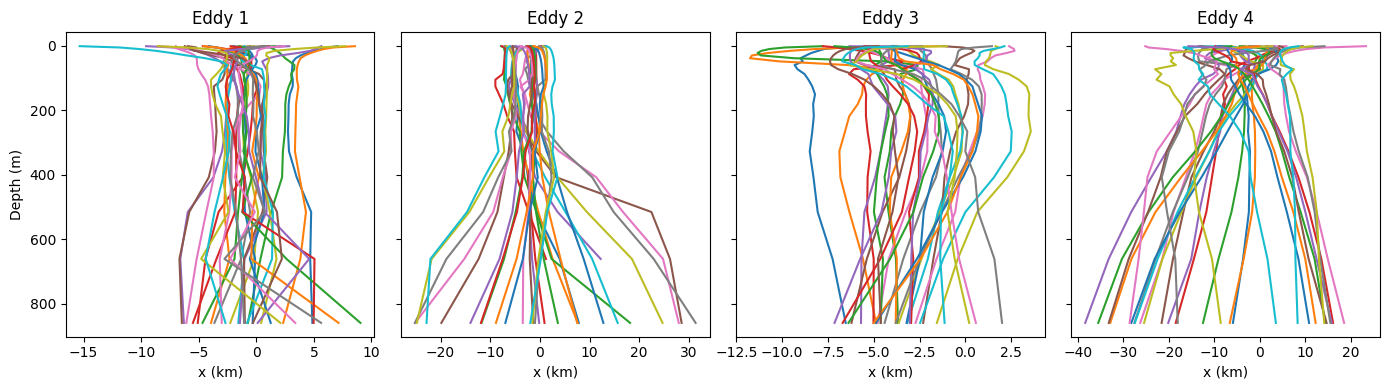

In [14]:
fig, axs = plt.subplots(1, 4, figsize=(14,4), sharey=True)

for i, eddy in enumerate(the_frontier_eddies):

    for t in range(0, 30):
    
        df = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t)]
        axs[i].plot(df['xc'], -df['Depth'])
        
    axs[i].set_title(f'Eddy {i+1}')
    
    axs[i].set_xlabel('x (km)')
    axs[i].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (m)')
axs[0].set_ylabel('Depth (m)')
axs[0].invert_yaxis()

plt.tight_layout()
plt.show()


### Plotting

In [15]:
eddy1 = [the_frontier_eddies[0]] * 3 
t1 = [0, 5, 15, 25, 29]
z1 = [3, 0, 3, 20, 0]

eddy2 = [the_frontier_eddies[1]] * 9
t2 = [0, 10, 10, 10, 10, 20, 29]
z2 = [20, 3, 15, 20, 5, 5, 20]

eddy3 = [the_frontier_eddies[2]] * 14
t3 = [0, 5, 10, 10, 15, 15, 15, 25, 25, 25, 25, 25, 29, 29]
z3 = [5, 0, 5, 15, 0, 3, 9, 0, 3, 9, 15, 20, 15, 20]

eddy4 = [the_frontier_eddies[3]] * 10
t4 = [0, 0, 0, 5, 10, 10, 15, 20, 20, 29]
z4 = [5, 8, 20, 20, 3, 20, 20, 8, 20, 20]

df_show_offs = pd.DataFrame({
    'Eddy': eddy1 + eddy2 + eddy3 + eddy4,
    'Day': t1 + t2 + t3 + t4,
    'z': z1 + z2 + z3 + z4
    })


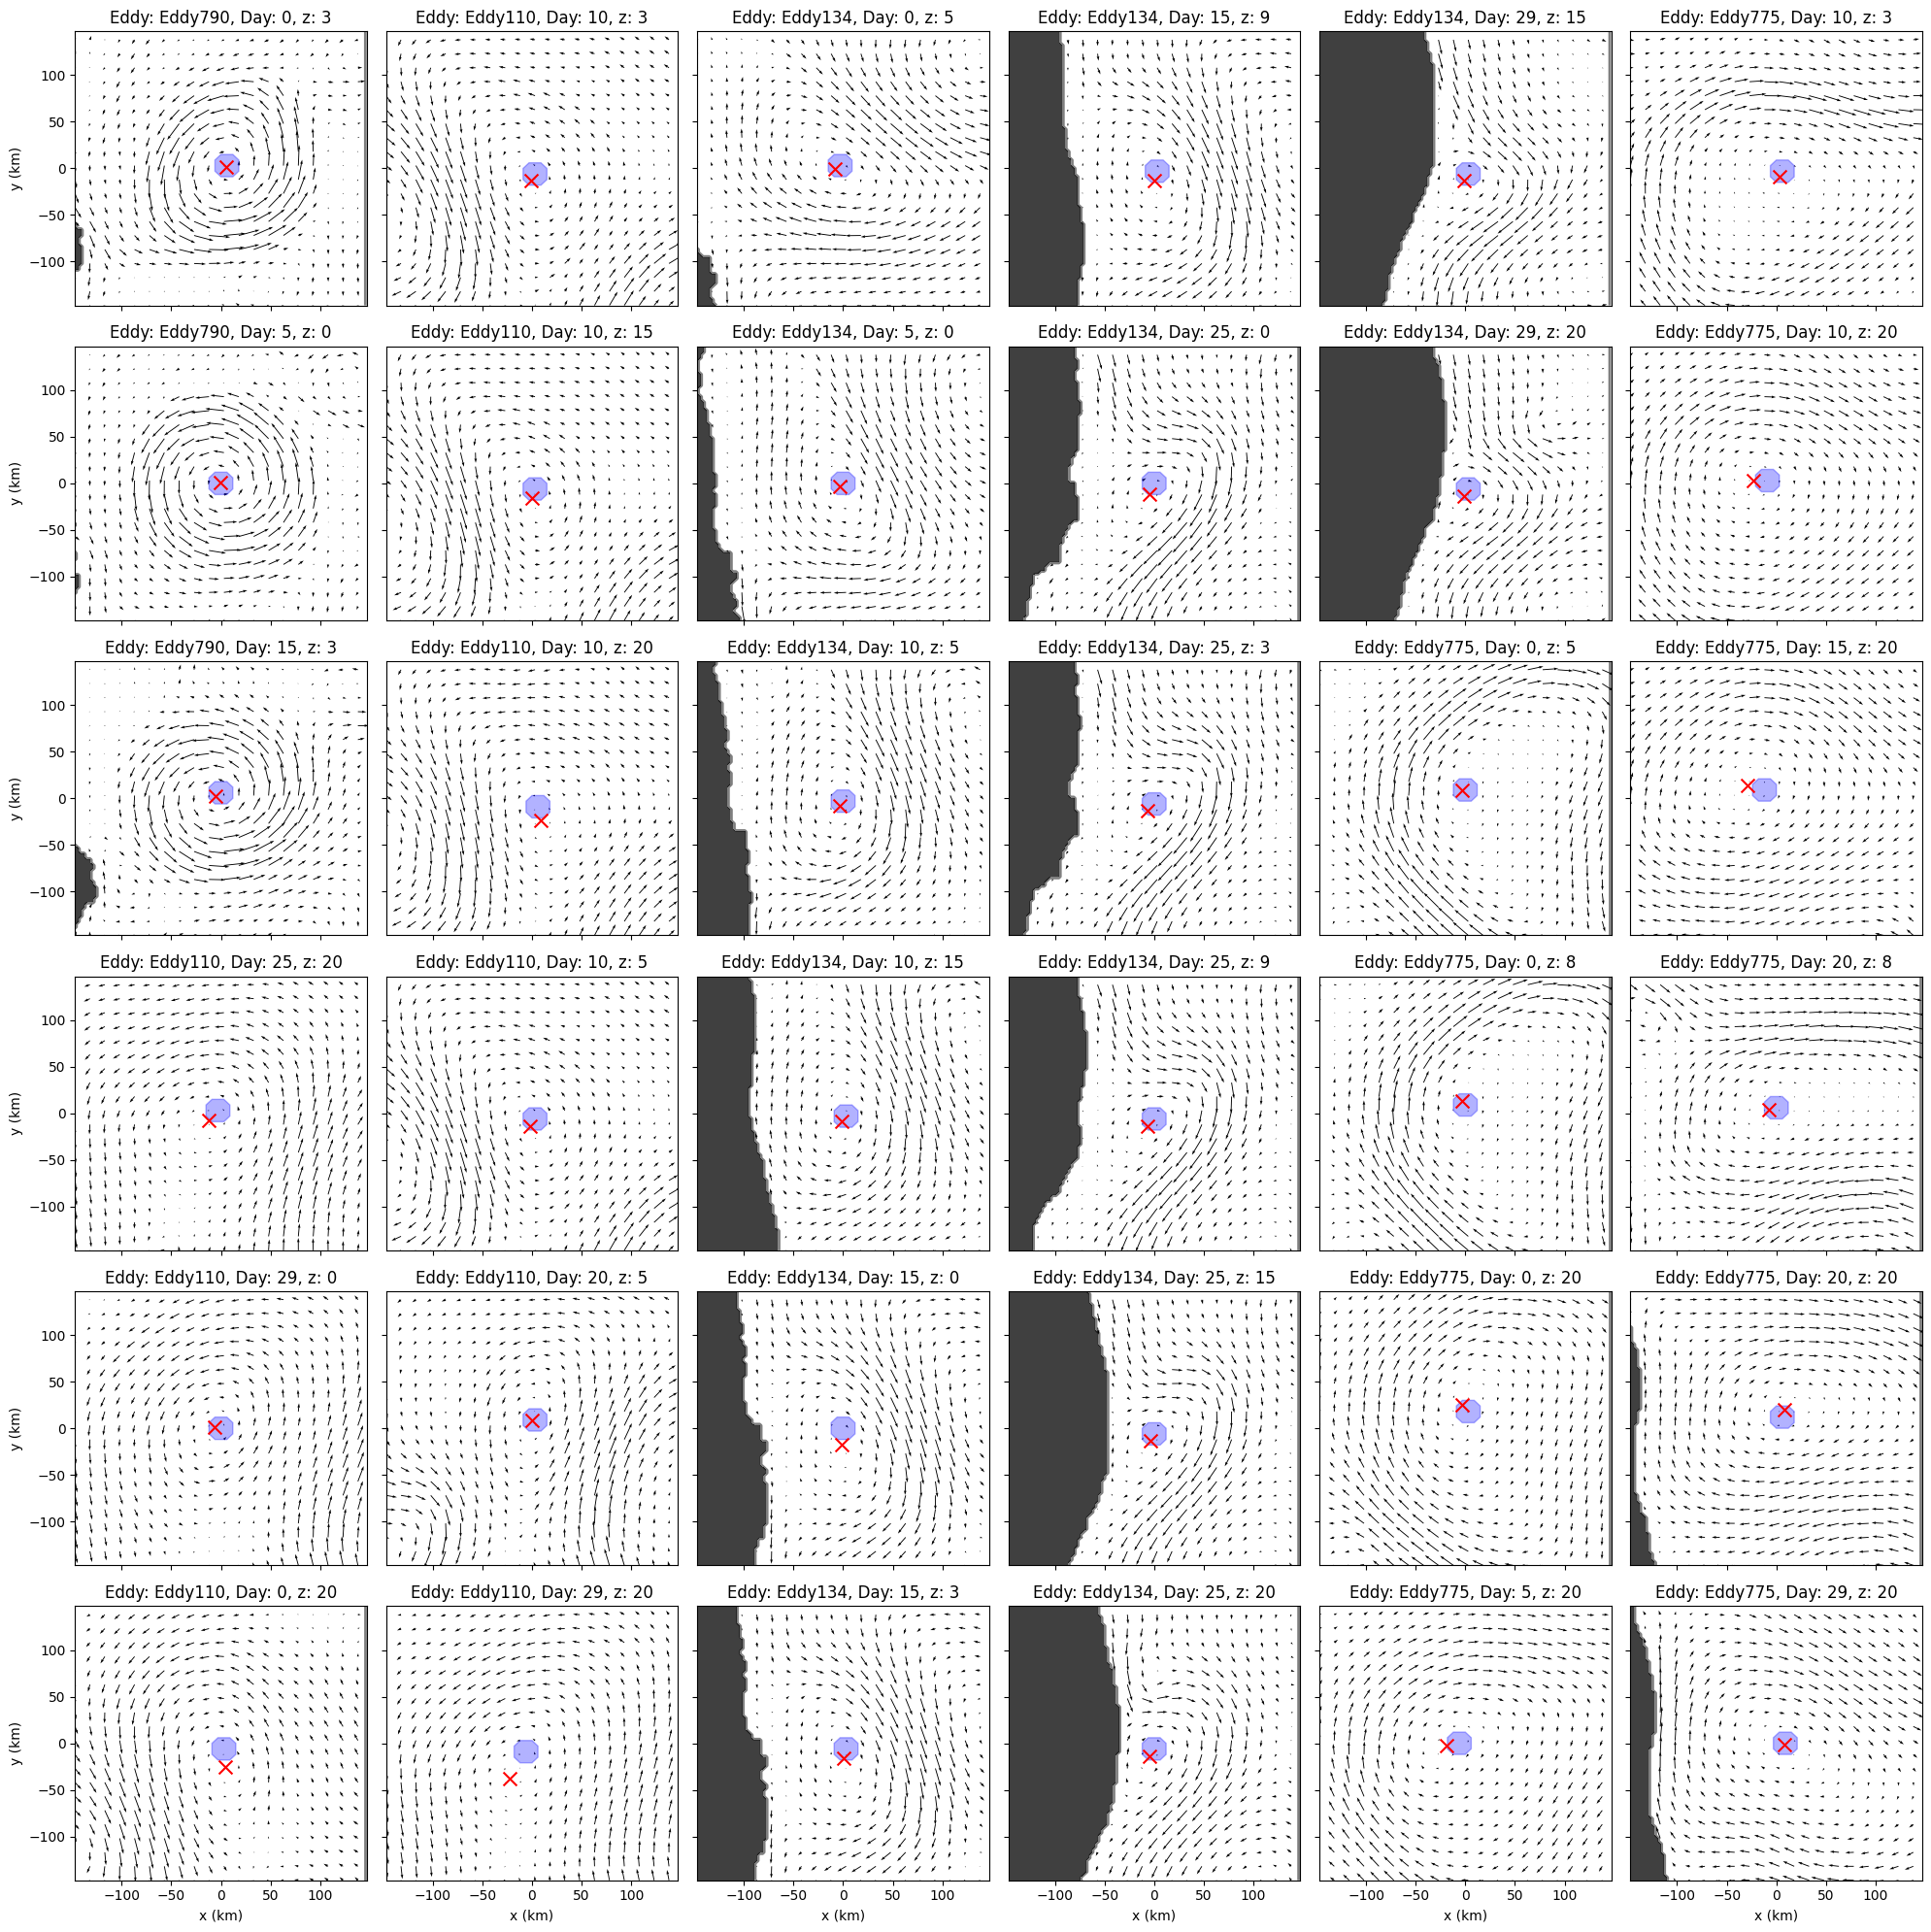

In [16]:
from scipy.spatial import ConvexHull

rows, cols = 6, 6

fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharey=True, sharex=True)

for k in range(len(df_show_offs)):

    ax = axs[k % rows, k//rows]

    df_rel = df_show_offs.iloc[k]
    eddy, t, depth_lvl = df_rel['Eddy'], df_rel['Day'], df_rel['z']

    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]

    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    ax.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        ax.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)
    
    ax.scatter(xc, yc, marker='x', s=100, color='r', zorder=4)

    if np.any(np.isnan(u_roms)):
        nan_mask = np.isnan(u_roms)
        mask = np.where(~np.isnan(u_roms), np.nan, 0)
        ax.contourf(X_roms, Y_roms, mask.T, cmap='gray', zorder=-1)
        ax.contour(X_roms, Y_roms, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    ax.set_title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')
    
    if k % rows == rows - 1:
        ax.set_xlabel('x (km)')
    if k < rows:
        ax.set_ylabel('y (km)')

    # ax.axis('equal')

plt.tight_layout()
plt.show()

In [17]:
def plotter(eddy, t, depth_lvl):
    fig = plt.figure(figsize=(4,4))
    u_roms = sample_data[eddy]['T'+str(t)]['U'][:, :, depth_lvl]
    v_roms = sample_data[eddy]['T'+str(t)]['V'][:, :, depth_lvl]
    
    x_roms, y_roms = sample_data[eddy]['T'+str(t)]['x']/1000, sample_data[eddy]['T'+str(t)]['y']/1000
    X_roms, Y_roms, dx_roms = *np.meshgrid(x_roms, y_roms), x_roms[1]-x_roms[0]
    
    spacing = 5
    plt.quiver(X_roms[::spacing, ::spacing], Y_roms[::spacing, ::spacing], u_roms[::spacing, ::spacing].T, v_roms[::spacing, ::spacing].T)

    df_rel = df_MOCA[(df_MOCA['Eddy']==eddy) & (df_MOCA['Day']==t) & (df_MOCA['z']==depth_lvl)]

    xc, yc, nic, njc, depth, w = df_rel['xc'], df_rel['yc'], df_rel['nic'], df_rel['njc'], df_rel['Depth'], df_rel['w']

    mask = (np.hypot(X_roms - X_roms[nic, njc], Y_roms - Y_roms[nic, njc]) < r_roms*dx_roms).T
    points = np.column_stack((X_roms[mask], Y_roms[mask]))
    
    if len(points) > 2:  # Convex hull requires at least 3 points
        hull = ConvexHull(points)
        plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color='b', alpha=0.3)
    
    plt.scatter(xc, yc, marker='x', s=100, color='r')

    plt.title(f'Eddy: {eddy}, Day: {t}, z: {depth_lvl}')


In [19]:
# for eddy in the_frontier_eddies:
#     for t in [0, 5, 10, 15, 20, 25, 29]:
#         for depth_lvl in [0, 3, 5, 8, 9, 15, 20]:

#             plotter(eddy, t, depth_lvl)

## RV Investigator


In [157]:
df_RV = pd.read_csv("MNF_IN2017_V04_adcp_trawler.csv")

In [158]:
np.sort(df_RV['Depth'].unique())

array([ 22.5,  30. ,  30.5,  38.5,  46. ,  46.5,  54.5,  62. ,  62.5,
        70.5,  78. ,  78.5,  86.5,  94. ,  94.5, 102.5, 110. , 110.5,
       118.5, 126. , 126.5, 134.5, 142. , 142.5, 150.5, 158. , 158.5,
       166.5, 174. , 174.5, 182.5, 190. , 190.5, 198.5, 206. , 206.5,
       214.5, 222. , 222.5, 230.5, 238. , 238.5, 246.5, 254. , 254.5,
       262.5, 270. , 270.5, 278.5, 286. , 286.5, 294.5, 302. , 302.5,
       310.5, 318. , 318.5, 326.5, 334. , 334.5, 342.5, 350. , 350.5,
       358.5, 366. , 366.5, 374.5, 382. , 382.5, 390.5, 398. , 398.5,
       406.5, 414. , 414.5, 422.5, 430. , 430.5, 438.5, 446. , 446.5,
       454.5, 462. , 462.5, 470.5, 478. , 478.5, 486.5, 494. , 494.5,
       510. , 526. , 542. , 558. , 574. , 590. , 606. , 622. , 638. ,
       654. , 670. , 686. , 702. , 718. , 734. , 750. , 766. , 782. ,
       798. , 814. , 830. , 846. ])

In [237]:
# 14
depths = [22.5, 110, 238, 702]
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for i, depth in enumerate(depths):

    ax = axs[i]
    
    df = df_RV[(df_RV["Start (UTC)"].astype(str).str.contains("15-SEP", na=False)) & (df_RV["Depth"]==depth)]
    
    lon, lat = np.deg2rad(df['Mean Lon']), np.deg2rad(df['Mean Lat'])
    # xi, yi = (lon - np.mean(lon))*110*np.cos(np.mean(lat)), (lat - np.mean(lat))*110
    xi, yi = np.rad2deg(lon), np.rad2deg(lat)
    
    ui, vi = df['U (m/sec)'], df['V (m/sec)']
    ax.quiver(xi, yi, ui, vi, width=None, zorder=3)
    xc, yc, q11, q12, q22, w = moca_space(xi, yi, ui, vi)
    ax.scatter(xc, yc)
    ax.axis('equal')

    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    # Stream Function
    # q11 *= -1
    # q12 *= -1
    # q22 *= -1
    det = q11*q22 - q12**2
    print(det)
    x_e = np.linspace(xlims[0], xlims[1], 101)  
    y_e = np.linspace(ylims[0], ylims[1], 101) 
    X_e, Y_e = np.meshgrid(x_e, y_e)
    Q = np.array([[q11, q12], [q12, q22]])
    XY = np.stack((X_e - xc, Y_e - yc), axis=-1)  # Shape (101, 101, 2)
    Psi_e = np.einsum("...i,ij,...j->...", XY, Q, XY)
    u_e = (-2*q22*(Y_e-yc) - 2*q12*(X_e-xc)).T
    v_e =  (2*q11*(X_e-xc) + 2*q12*(Y_e-yc)).T
    ax.contour(X_e, Y_e, Psi_e, 20)

    ax.set_title(f'Depth: {depth}m')

xmin, xmax = np.inf, -np.inf
ymin, ymax = np.inf, -np.inf

for ax in axs:
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    xmin, xmax = min(xmin, x0), max(xmax, x1)
    ymin, ymax = min(ymin, y0), max(ymax, y1)

for ax in axs:
    ax.set_xlim((xmin, xmax))
    ax.set_ylim((ymin, ymax))

plt.tight_layout()
plt.show()

0.14290071679827956
0.2418583266379685
0.34545373065685686
0.06747733744854381


In [209]:
ymin

np.float64(-35.803976066150724)